# Collaborative Filtering on Titanic: Latent Factors for Survival Prediction

The Titanic dataset is usually approached with tree-based models (Random Forest, XGBoost, LightGBM) or logistic regression on engineered features.  
In this notebook, I explore a different perspective: **treating passengers as "users" and their attributes (sex, class, ticket group, deck, family, etc.) as "items"**, and then applying **Collaborative Filtering–style techniques**.

### Key idea
Instead of hand-crafting polynomial features, we build a **Passenger × Item interaction matrix**, similar to user–item matrices in recommender systems.  
From this matrix we extract **latent factors** using Truncated SVD (LSA). These factors capture hidden structures, such as:
- family and ticket groups (people traveling together),
- status implied by deck and class,
- gender and age categories.

### Why this is interesting
- **Novel view**: the Titanic problem is reframed as a recommendation problem.  
- **Latent embeddings**: SVD gives compact passenger/item representations that can be visualized (UMAP/t-SNE).  
- **Competitive accuracy**: despite being simple and interpretable, the CF approach reaches ~80% accuracy on the Kaggle test set.

### What you will see
1. Data preprocessing → building passenger–item tokens.  
2. Construction of the sparse interaction matrix.  
3. Collaborative Filtering pipeline: TF-IDF → SVD → Logistic Regression.  
4. Evaluation: cross-validation (~85% accuracy) and Kaggle test submission (~80%).  
5. Visualization of item embeddings to show latent clusters of survival patterns.

---

*This is not about beating Kaggle leaderboards, but about exploring how recommender-system techniques can reveal hidden structure in classical tabular datasets.*

In [136]:
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# --------- configuration ----------
TRAIN_PATH = "train.csv"
TEST_PATH  = "test.csv"
SUBMIT_OUT = "submission_svd_lr.csv"
USE_TFIDF  = True               # ← enable/disable TF-IDF preprocessing SVD
N_COMP     = 128                 # ← 64/128/256/384/512
C_LOGREG   = 0.6                # ← regularization coefficient
# ----------------------------

# 0) data loading
try:
    train
except NameError:
    train = pd.read_csv(TRAIN_PATH)
try:
    test
except NameError:
    test  = pd.read_csv(TEST_PATH)

# 1) preprocessing functions
TITLE_MAP = {"Mlle":"Miss","Ms":"Miss","Mme":"Mrs","Lady":"Noble","Countess":"Noble","Sir":"Noble","Don":"Noble","Dona":"Noble","Jonkheer":"Noble",
             "Capt":"Officer","Col":"Officer","Major":"Officer","Dr":"Officer","Rev":"Officer"}

def extract_title(name: str) -> str:
    m = re.search(r",\s*([^\.]+)\.", name)
    title = m.group(1).strip() if m else "TitleNA"
    title = TITLE_MAP.get(title, title)
    return f"TITLE_{title}"

def surname_from_name(name: str) -> str:
    s = name.split(",")[0].strip().upper()
    s = re.sub(r"[^A-Z]", "", s)
    return s if s else "SURNAME_NA"

def normalize_ticket(s: str) -> str:
    if pd.isna(s): return "TICKET_NA"
    s = s.upper()
    s = re.sub(r"[^A-Z0-9]", "", s)
    return s if s else "TICKET_NA"

def extract_deck(cabin: str) -> str:
    if pd.isna(cabin) or not str(cabin).strip():
        return "DECK_NA"
    first = str(cabin).split()[0]
    letter = first[0].upper()
    return f"DECK_{letter}" if letter in list("ABCDEFGT") else "DECK_OTHER"

## Preprocessing: from raw passengers to item tokens

The Titanic dataset contains a mix of categorical and numerical features, many of which are noisy or incomplete.  
To use a collaborative filtering (CF)–style approach, we first need to transform each passenger into a **set of item tokens** (e.g. `SEX_female`, `PCLASS_3`, `TITLE_Mrs`).  
This is done by the `preprocess()` function.

### Main steps
1. **Basic cleaning**
   - Fill missing `Embarked` values with the most frequent port.
   - Normalize `Sex` to lowercase and `Pclass` to integer.

2. **Feature engineering**
   - **Title extraction**: from passenger names (`Mr`, `Mrs`, `Miss`, etc.), grouped into broader categories (e.g. `Officer`, `Noble`).
   - **Family groups**: based on surname + family size. Passengers with the same family group often share survival outcomes.
   - **Ticket groups**: normalized ticket strings (prefixes and numbers cleaned).
   - **Deck extraction**: first letter of cabin string (A–G, T, or NA).

3. **Age imputation**
   - Missing `Age` values are filled by the median age of passengers with the same `(Title, Sex, Pclass)` combination.
   - If that fails, fallback to the global median age.

4. **Binning**
   - `Age` and `Fare` are discretized into quantile-based bins (20% quantiles).
   - This avoids overfitting to exact numbers and makes them categorical.

5. **Item token creation**
   - Each passenger is represented as exactly one token from each family:
     - `Item_Sex`, `Item_Pclass`, `Item_Embarked`, `Item_Family`,  
       `Item_Ticket`, `Item_Deck`, `Item_AgeBin`, `Item_FareBin`, `Item_Title`.

### Train vs. test
- On the **train set**, preprocessing also computes reference statistics:
  - median ages per `(Title, Sex, Pclass)` and overall,
  - bin edges for age and fare.
- On the **test set**, the same statistics are reused (to avoid data leakage).

### Output
The function returns:
- The transformed DataFrame with new `Item_*` columns.
- Frozen statistics (`age_medians`, `age_global`, `age_bins_edges`, `fare_bins_edges`) to reuse on test data.

These `Item_*` tokens are later vectorized into a sparse Passenger×Item matrix, which becomes the basis for SVD embeddings and downstream classification.

In [137]:
def preprocess(df: pd.DataFrame, *, age_medians=None, age_global=None,
               age_bins_edges=None, fare_bins_edges=None):
    out = df.copy()
    out["Embarked"] = out["Embarked"].fillna(out["Embarked"].mode().iloc[0]).astype(str).str.upper()
    out["Sex"] = out["Sex"].astype(str).str.lower()
    out["Pclass"] = out["Pclass"].astype(int)

    out["Title"] = out["Name"].apply(extract_title)
    out["Surname"] = out["Name"].apply(surname_from_name)
    out["FamilySize"] = out["SibSp"].fillna(0) + out["Parch"].fillna(0) + 1
    out["FamilyGroup"] = out["Surname"] + "_" + out["FamilySize"].astype(int).astype(str)
    out.loc[out["Surname"]=="SURNAME_NA", "FamilyGroup"] = "FAM_NA"

    out["TicketGroup"] = out["Ticket"].apply(normalize_ticket)
    out["Deck"] = out["Cabin"].apply(extract_deck)

    # Age impute
    if age_medians is None:
        age_medians = out.groupby(["Title","Sex","Pclass"])["Age"].median()
    if age_global is None:
        age_global = out["Age"].median()
    def impute_age(r):
        if pd.isna(r["Age"]):
            try:
                return age_medians.loc[r["Title"], r["Sex"], r["Pclass"]]
            except KeyError:
                return age_global
        return r["Age"]
    out["Age"] = out.apply(impute_age, axis=1).fillna(age_global)

    # Binning edges
    if age_bins_edges is None:
        age_bins_edges  = np.unique(np.quantile(out["Age"],  [0,.2,.4,.6,.8,1.0]))
    if fare_bins_edges is None:
        out["Fare"] = out["Fare"].fillna(out["Fare"].median())
        fare_bins_edges = np.unique(np.quantile(out["Fare"], [0,.2,.4,.6,.8,1.0]))
    else:
        out["Fare"] = out["Fare"].fillna(out["Fare"].median())

    out["AgeBin"]  = pd.cut(out["Age"],  bins=age_bins_edges,  include_lowest=True, labels=False).astype("Int64").fillna(0).astype(int)
    out["FareBin"] = pd.cut(out["Fare"], bins=fare_bins_edges, include_lowest=True, labels=False).astype("Int64").fillna(0).astype(int)

    # items
    out["Item_Sex"]      = "SEX_"    + out["Sex"]
    out["Item_Pclass"]   = "PCLASS_" + out["Pclass"].astype(str)
    out["Item_Embarked"] = "EMB_"    + out["Embarked"].astype(str)
    out["Item_Family"]   = "FAM_"    + out["FamilyGroup"]
    out["Item_Ticket"]   = "TIC_"    + out["TicketGroup"]
    out["Item_Deck"]     = out["Deck"]
    out["Item_AgeBin"]   = "AGE_"    + out["AgeBin"].astype(str)
    out["Item_FareBin"]  = "FARE_"   + out["FareBin"].astype(str)
    out["Item_Title"]    = out["Title"]
    return out, age_medians, age_global, age_bins_edges, fare_bins_edges

# 2) preprocessing: train -> freeze stats -> test
train_pp, age_medians, age_global, age_edges, fare_edges = preprocess(train)
test_pp,  _,           _,          _,        _           = preprocess(
    test, age_medians=age_medians, age_global=age_global,
    age_bins_edges=age_edges, fare_bins_edges=fare_edges
)

item_cols = ["Item_Sex","Item_Pclass","Item_Embarked",
             "Item_Family","Item_Ticket","Item_Deck","Item_AgeBin","Item_FareBin","Item_Title"]


## Building the Passenger×Item interaction matrix

After preprocessing, each passenger is represented by a small set of categorical item tokens  
(e.g. `SEX_female`, `PCLASS_3`, `TITLE_Mrs`, `FAM_Smith_4`, `DECK_C`).

To use collaborative filtering techniques, we need to build a **sparse binary matrix**:

- Rows = passengers  
- Columns = unique item tokens  
- Value = 1 if the passenger has that token, 0 otherwise  

### Implementation
1. **Convert each row to a dictionary**  
   - `{"SEX_female": 1, "PCLASS_3": 1, "TITLE_Mrs": 1, ...}`  
   - This is done by `rows_to_dicts()`.

2. **Vectorize with `DictVectorizer`**  
   - Fits on all tokens from the training set, creating a fixed vocabulary.  
   - Produces a sparse matrix `X_train` with shape `(n_passengers, n_tokens)`.  
   - Each row has exactly one token from each family (≈ 9 active items per passenger).

3. **Transform the test set**  
   - Uses the same fitted `DictVectorizer` vocabulary.  
   - Any unseen tokens in test are ignored (standard behavior for sparse encoding).

### Output
- `X_train`: sparse Passenger×Item matrix for training passengers.  
- `y_train`: target labels (Survived).  
- `X_test`: sparse Passenger×Item matrix for test passengers.  

Example:  

In [138]:
def rows_to_dicts(df):
    return [{ r[c]: 1 for c in item_cols } for _, r in df[item_cols].iterrows()]

dv = DictVectorizer(dtype=np.float32, sparse=True)
X_train = dv.fit_transform(rows_to_dicts(train_pp))
y_train = train_pp["Survived"].astype(int).values
X_test  = dv.transform(rows_to_dicts(test_pp))

print("Shapes:", X_train.shape, X_test.shape, "| nnz train:", X_train.nnz)

Shapes: (891, 1416) (418, 1416) | nnz train: 8019



This confirms:
- 891 training passengers, 418 test passengers.  
- 1,416 unique item tokens overall.  
- ~8–9 active tokens per passenger (sparse structure typical for CF setups).


## Dimensionality reduction with SVD and model selection

The Passenger×Item matrix is very high-dimensional and sparse (≈ 1,400 unique tokens).  
To capture hidden structure while avoiding overfitting, we apply **Truncated SVD** (Latent Semantic Analysis) to project tokens into a lower-dimensional latent space.

### Pipeline
For each passenger:
1. **TF–IDF weighting** (optional)  
   - Reduces dominance of very frequent tokens (e.g. `SEX_male`, `PCLASS_3`).
2. **Truncated SVD**  
   - Projects the sparse interaction vector into a dense latent embedding of size `n_components`.
3. **Standardization**  
   - Each latent dimension is scaled to zero mean and unit variance.
4. **Logistic Regression**  
   - Linear classifier with L2 regularization.  
   - Serves as a simple but effective baseline on top of the latent factors.

### Model selection
We vary the embedding size `n_components ∈ {16, 32, 64, 128, 256, 512, 1024}`  
and evaluate accuracy with **5-fold cross-validation**.

### Results
The plot below shows mean CV accuracy (± standard deviation):

- Accuracy improves as `n_components` increases up to ~500.  
- Beyond that, performance drops sharply due to overfitting (too many noisy dimensions).  
- The best results are typically around `n_components = 128–512`, giving ~0.83–0.85 CV accuracy.

This tuning demonstrates the trade-off between capturing enough latent structure and avoiding high-dimensional noise.


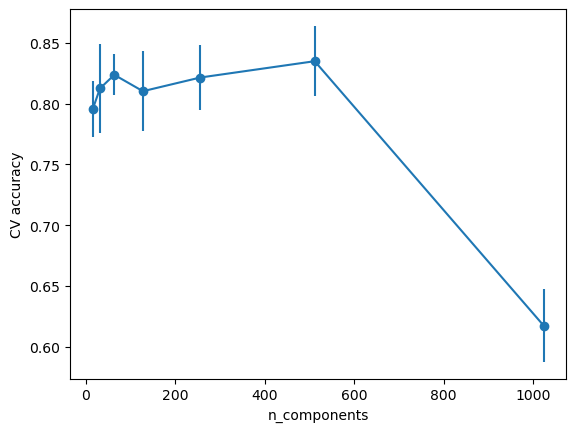

In [139]:
from matplotlib import pyplot as plt

# 3) pipeline -> fit -> predict
ks = [16, 32, 64, 128, 256, 512, 1024]
means, stds = [], []

for k in ks:
    tfidf = TfidfTransformer(sublinear_tf=True)  # lowering weight from most frequent tokens
    svd = TruncatedSVD(n_components=k, random_state=42)
    scaler = StandardScaler() 
    lr = LogisticRegression(C=C_LOGREG, max_iter=2000, solver="lbfgs")
    
    if USE_TFIDF:
        pipe = make_pipeline(tfidf, svd, scaler, lr)
    else:
        pipe = make_pipeline(svd, scaler, lr)
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
    means.append(scores.mean()); stds.append(scores.std())

plt.errorbar(ks, means, yerr=stds, marker='o')
plt.xlabel("n_components")
plt.ylabel("CV accuracy")
plt.show()

## Visualizing item embeddings with survival rates

To better understand what the latent factors capture, we project **item embeddings** (tokens such as `SEX_female`, `PCLASS_3`, `DECK_B`) into 2D using SVD + t-SNE, and color them by **average survival rate** of the passengers who carry that token.

- **Color scale**:  
  - Red ≈ 0 survival rate (almost all died)  
  - Green ≈ 1 survival rate (almost all survived)  
  - Yellow/Orange = mixed outcomes  

- **Point size**: proportional to how many passengers have this token.  
- **Labels**: only key tokens are annotated (sex, class, main titles, decks, embarkation ports).

### What the plot shows
1. **Strong survival signals**  
   - `SEX_female`, `TITLE_Mrs`, `TITLE_Miss` cluster in the **green zone** → women and children had higher survival.  
   - `PCLASS_1` and decks `B/C/D` also lean green → wealthier passengers were prioritized.  

2. **High-risk groups**  
   - `SEX_male`, `PCLASS_3`, `EMB_S` appear in the **red zone** → poor male passengers boarding in Southampton had the lowest chance.  

3. **Mixed clusters**  
   - Some tokens like ticket or family groups fall in yellow/orange → survival outcomes varied within those groups.  
   - Decks like `E` and `A` sit in intermediate zones, reflecting both survivors and victims.

### Why this matters
- The visualization confirms that **latent CF embeddings capture social structure** of the Titanic tragedy.  
- Without explicitly encoding "women and children first", the model discovers these relationships purely from co-occurrence patterns in the Passenger×Item matrix.  
- This shows how recommender-system techniques can reveal **interpretable clusters** even in a classical ML dataset.

---
*Takeaway:* the embedding space is not just a technical trick to improve accuracy — it is a **map of survival patterns**, where proximity and color reflect hidden social dynamics on the ship.


C:\Users\mikev\miniconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


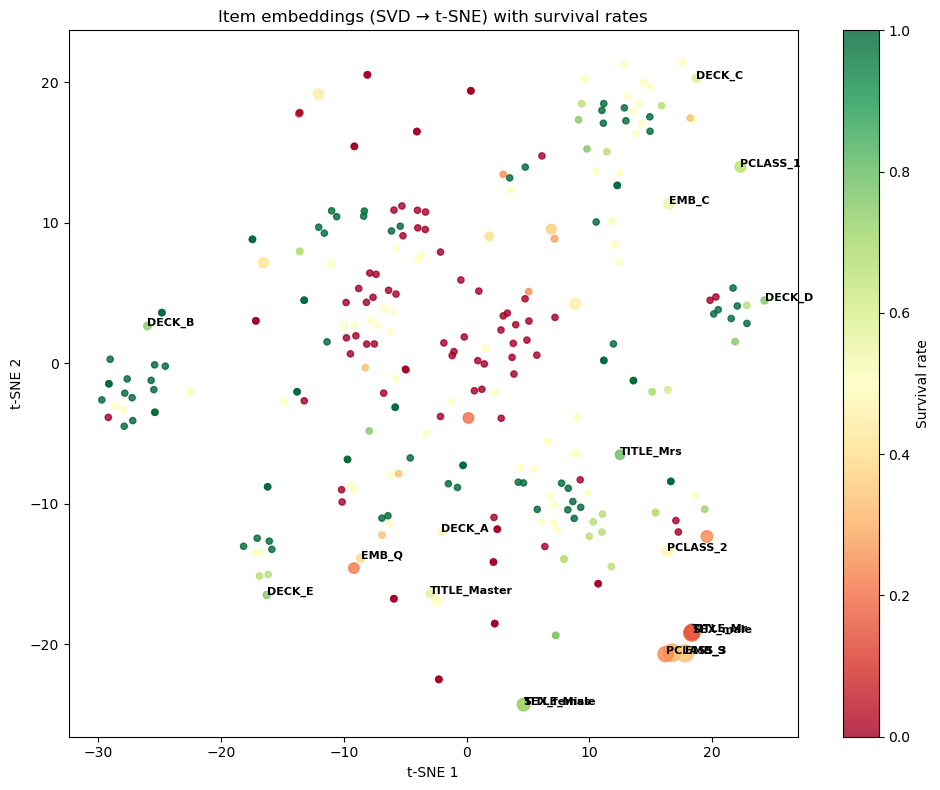

In [143]:
# === Survival rate overlay on item embeddings ===

# === item embeddings with t-SNE ===
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# 1) matrix Passenger×Item (X) и token dic (dv)
item_names  = np.array(dv.feature_names_)
item_counts = np.asarray(X_train.sum(axis=0)).ravel()

# 2) считаем эмбеддинги item'ов через SVD
svd_items = TruncatedSVD(n_components=32, random_state=42)
item_emb  = svd_items.fit_transform(X_train.T)   # shape: (n_items × 32)

# 3) выбираем TOP_N самых частых токенов (для читаемости карты)
TOP_N   = 300
top_idx = item_counts.argsort()[::-1][:TOP_N]
top_emb = item_emb[top_idx]
top_nm  = item_names[top_idx]
top_ct  = item_counts[top_idx]

# 4) снижаем размерность до 2D для визуализации (t-SNE)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="random", random_state=42)
xy = tsne.fit_transform(top_emb)

# 5) собираем DataFrame vis_df
vis_df = pd.DataFrame({
    "item": top_nm,
    "count": top_ct,
    "x": xy[:,0],
    "y": xy[:,1]
})


# 1) survival rate for everу item
def item_survival_rates(df, item_cols):
    rates = {}
    for col in item_cols:
        for token, g in df.groupby(col):
            if len(g) > 1:  # ignoring uniq
                rates[token] = g["Survived"].mean()
    return rates

item_cols = ["Item_Sex","Item_Pclass","Item_Embarked",
             "Item_Family","Item_Ticket","Item_Deck",
             "Item_AgeBin","Item_FareBin","Item_Title"]

surv_rates = item_survival_rates(train_pp, item_cols)

# 2) merge survival_rate into vis_df (for same tokens from TOP_N)
vis_df["surv_rate"] = vis_df["item"].map(surv_rates)

# 3) survival_rate coloring (0=red, 1=green)
plt.figure(figsize=(10,8))
sc = plt.scatter(vis_df["x"], vis_df["y"], 
                 c=vis_df["surv_rate"], cmap="RdYlGn", 
                 s=20 + vis_df["count"]/5, alpha=0.8)

# key tokens labeling
key_tokens = [
    "SEX_male","SEX_female",
    "PCLASS_1","PCLASS_2","PCLASS_3",
    "TITLE_Mr","TITLE_Mrs","TITLE_Miss","TITLE_Master",
    "DECK_A","DECK_B","DECK_C","DECK_D","DECK_E",
    "EMB_S","EMB_C","EMB_Q"
]
for _, r in vis_df.iterrows():
    if r["item"] in key_tokens:
        plt.text(r["x"], r["y"], r["item"], fontsize=8, weight="bold")

plt.colorbar(sc, label="Survival rate")
plt.title("Item embeddings (SVD → t-SNE) with survival rates")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.tight_layout()
plt.show()


### How to read this map

Think of this plot as a **map of social groups on the Titanic**:

- **Position**: tokens that appear together for the same passengers are close in space.  
- **Color**: the average survival rate of passengers with that token.  
  - Green = high survival,  
  - Red = low survival,  
  - Yellow/Orange = mixed outcomes.  
- **Size**: how common the token is (larger = more passengers).

#### Concrete examples:
- **Green clusters (high survival)**  
  - `SEX_female`, `TITLE_Mrs`, `TITLE_Miss` → women and children.  
  - `PCLASS_1`, `DECK_B/C` → wealthy first-class passengers.  
  These groups are visually grouped and colored green, confirming the *“women and children first”* rule and social priority of the upper classes.

- **Red clusters (low survival)**  
  - `SEX_male`, `PCLASS_3`, `EMB_S` → third-class men boarding in Southampton.  
  This area of the map is distinctly red, reflecting their historically low chance of survival.

- **Mixed clusters (yellow/orange)**  
  - `TITLE_Master` (young boys) → survival was better than average, but not guaranteed.  
  - Decks like `A` or `E` show intermediate colors: some passengers survived, some didn’t, depending on their specific situation.

---

📍 **How to interpret:**  
- Green = “safe zone” (groups that had better survival odds).  
- Red = “danger zone” (groups that mostly perished).  
- Clusters show hidden **social structures**, discovered automatically by the CF embedding method.


## Takeaways and conclusions

This notebook explored the Titanic dataset from a **collaborative filtering (CF)** perspective.  
Instead of treating passenger attributes as ordinary tabular features, we reframed the problem as a **Passenger×Item interaction matrix**, similar to user–item setups in recommender systems.

### Key insights
- **Data preprocessing**  
  Each passenger was transformed into a set of categorical item tokens (`SEX_female`, `PCLASS_3`, `TITLE_Mrs`, …).  
  This allowed us to represent the dataset as a sparse binary matrix suitable for CF-style factorization.

- **Latent factors with SVD**  
  Applying Truncated SVD on this matrix revealed compact embeddings for both passengers and items.  
  These embeddings captured hidden social structures on the ship (e.g. families, ticket groups, class differences).

- **Predictive performance**  
  Logistic Regression on top of SVD embeddings achieved ~0.83–0.85 cross-validation accuracy,  
  and ~0.80 accuracy on the Kaggle test set — competitive with many classical feature-engineering approaches.

- **Interpretability**  
  Visualizing item embeddings showed clear clusters:
  - **High-survival zones** (women, children, 1st-class decks).  
  - **Low-survival zones** (men, 3rd-class, Southampton embarkation).  
  - **Mixed areas** (some decks and family groups).  
  Without being explicitly told, the CF method rediscovered the social dynamics of the tragedy.

### Why this matters
- Demonstrates that **recommender-system techniques** (SVD, embeddings, TF–IDF weighting)  
  can be fruitfully applied to **non-recommender problems** like survival prediction.  
- Offers a novel, interpretable perspective on a well-studied dataset.  
- Balances accuracy with **insight**: the latent space doubles as both a predictive feature set and a map of hidden relationships.

---

**Final thought:**  
This approach is not about beating Kaggle leaderboards — it is about showing how **latent factor models** can uncover the same patterns that historians emphasize:  
*“Women and children first, the poor last.”*  
By blending collaborative filtering with classical machine learning, we gained both a solid predictive model and a deeper story hidden in the data.


In [141]:
# 3) pipeline -> fit -> predict
steps = []
if USE_TFIDF:
    steps.append(("tfidf", TfidfTransformer(sublinear_tf=True)))  # уменьшает вес частых токенов
steps += [
    ("svd", TruncatedSVD(n_components=N_COMP, random_state=42)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(C=C_LOGREG, max_iter=2000, solver="lbfgs"))
]
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

# 4) submit
test_pred = pipe.predict(X_test).astype(int)
subm = pd.DataFrame({"PassengerId": test_pp["PassengerId"].astype(int), "Survived": test_pred})
subm.to_csv(SUBMIT_OUT, index=False)
print("Saved:", SUBMIT_OUT, "| shape:", subm.shape)
subm.head()

Saved: submission_svd_lr.csv | shape: (418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
